## Insurance 회귀 분석 캡스톤
- 왜 어떤 사람의 의료보험 청구 비용은 높고 낮을까?
    - 나이, 성별, 거주 지역, 생활 습관에 따라 달라짐
    - 흡연 여부는 의료비를 얼마나 크게 변화시킬까?
    - 젊은 사람도 흡연자라면 높은 비용을 지불할까?
    - 개인의 인구학적 건강 특성이 의료보험 청구 비용을 어떤 구조로 설명하는지를 데이터와 회귀모형을 통해 단계적으로 탐구
    - 목표는 "의료 비용 불평등은 어떤 논리로 형성되는가" 를 수치와 언어로 설명하는 것

In [ ]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from pandas import DataFrame

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr
from scipy.stats import shapiro, skew,kurtosis,normaltest,bartlett,levene, ttest_rel, mannwhitneyu,ttest_ind
from statannotations.Annotator import Annotator
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_gameshowell, pairwise_tests

from itertools import combinations

In [3]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [4]:
origin = load_data('insurance')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.


===== 데이터 크기 확인 =====
데이터셋 크기 : (1338, 7)
열 개수: 7
행 개수: 1338

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- 데이터 기본 전처리 -카테고리 타입 지정
- smoker 변수 no=0, yes=1로 변경

In [6]:
df_raw = origin.copy()
df_raw = df_raw.astype({'sex':'category','smoker':'category', 'region':'category'})

display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


None

In [7]:
#smoker 변수 0과 1로 변환
df_raw['smoker'] = np.where(df_raw['smoker']=='yes', 1, 0)
df_raw

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,0,northwest,10600.54830
1334,18,female,31.920,0,0,northeast,2205.98080
1335,18,female,36.850,0,0,southeast,1629.83350
1336,21,female,25.800,0,0,southwest,2007.94500


### 미션 1. 이 데이터는 믿을만할까?
- 결측, 이상치, 편향을 점검하고, 처리 기준을 제시한다.
- charges가 음수이거나 극단값인지, age/bmi 등의 범위가 현실적인지 확인한다.
- 범주형 변수(sex, smoker, region)가 몇 개의 범주로 구성되어 있고, 특정 범주에 데이터가 몰려 있지는 않는지 확인한다.
- 전처리 전,후가 어떻게 달라졌는지 한 눈에 비교하는 표나 요약을 만든다.
- 단위 해석 주의 : charges는 USD이므로 현실적인 의료비 수준인지 평가하세요.

#### 기술통계량 확인

In [8]:
# 수치형 요약 통계를 확인함
df_raw.describe()

,age,bmi,children,smoker,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.204783,13270.422265
std,14.049960,6.098187,1.205493,0.403694,12110.011237
min,18.000000,15.960000,0.000000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,0.000000,9382.033000
75%,51.000000,34.693750,2.000000,0.000000,16639.912515
max,64.000000,53.130000,5.000000,1.000000,63770.428010


데이터의 평균 분포가 서로 상이하므로 (특히 나이와 bmi) 로그나 데이터 표준화 등의 처리가 필요할듯

#### 2. 결측치 비율 확인

In [9]:
# 결측률을 내림차순으로 확인함
df_raw.isna().mean().sort_values(ascending=False)*100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

- 결측치가 없음 ! ! ! 대박

#### 3. 중복행수

In [10]:
#중복 행 수를 집계함
df_raw.duplicated().sum()

np.int64(1)

중복 행이 하나 존재하므로 삭제

In [11]:
# 중복 행을 삭제함
df = df_raw.drop_duplicates().reset_index(drop=True)
df.shape

(1337, 7)

#### 4. charges의 값이 음수,극단인지, age/bmi의 범위가 현실적인지 확인

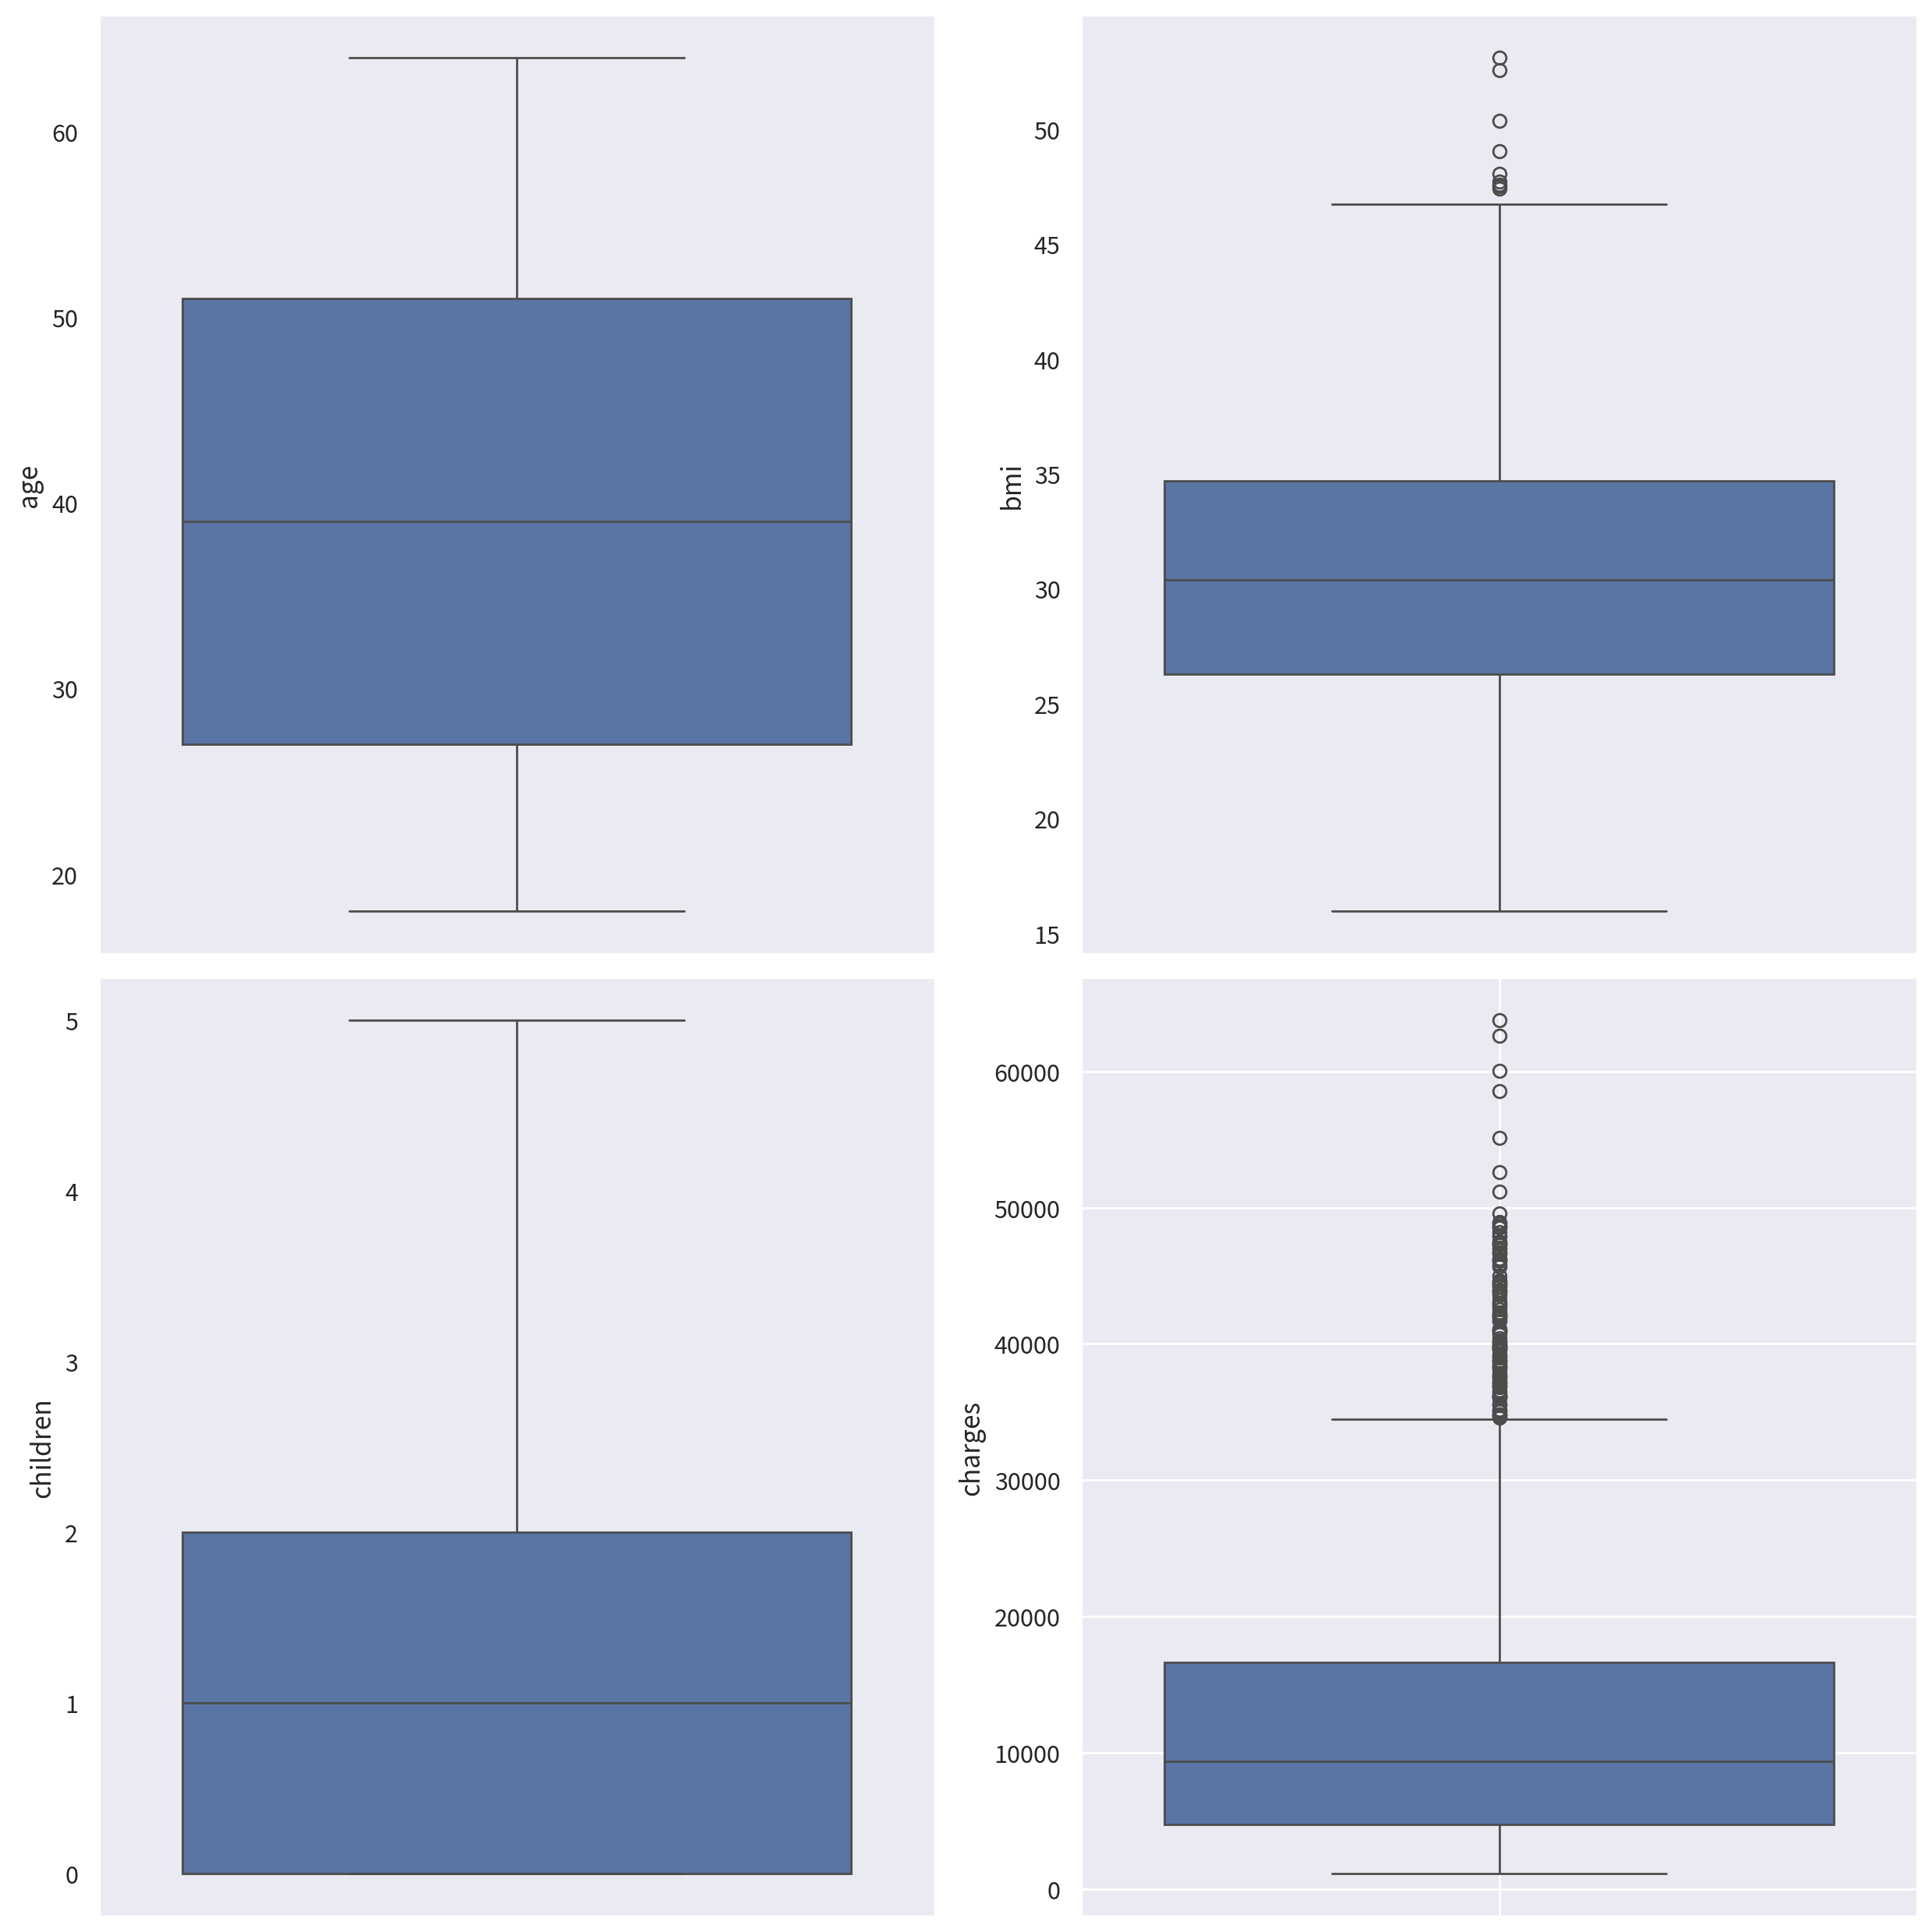

In [12]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 2                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df['age'],orient='v',ax=ax[0][0])
sb.boxplot(data=df['bmi'],orient='v',ax=ax[0][1])
sb.boxplot(data=df['children'],orient='v',ax=ax[1][0])
sb.boxplot(data=df['charges'],orient='v',ax=ax[1][1])
# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- BMI에 이상치가 발견되는데 max값이 53으로 현실적인 범위라고 생각할 수 있음. 
- 몸무게=55 x 키m^2 이니까 
    - 키가 160인 사람이 140.8키로 나가면 가능..
- charges의 최댓값이 63770USD 로 우리나라 돈으로 93,226,638원임.. 미국이라고 생각해도 값이 좀 이상한 느낌 하지만, 3.5만 달러~ 5만달러까지 데이터가 꽤 몰려있는 것을 보면 6만달러가 말이 안되는 가격이 아닐 수 있음.
    - 일단 그대로 두고 분석 진행

### 미션 2. 의료비와 핵심 변수의 첫인상
- 1. charges, age, bmi, children 분포를 히스토그램/KDE로 확인하고 알 수 있는 객관적 사실을 서술한다.
- 2. 왜도/이상치가 회귀에 줄 수 있는 영향과 변환할 필요가 있는지 서술하시오.
- 3. 분포 비교는 동일 축 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약하세요.
- 4. 의료비의 long-tail 분포(극단적 고액 청구)가 해석에 미치는 영향도 짧게 언급하세요.

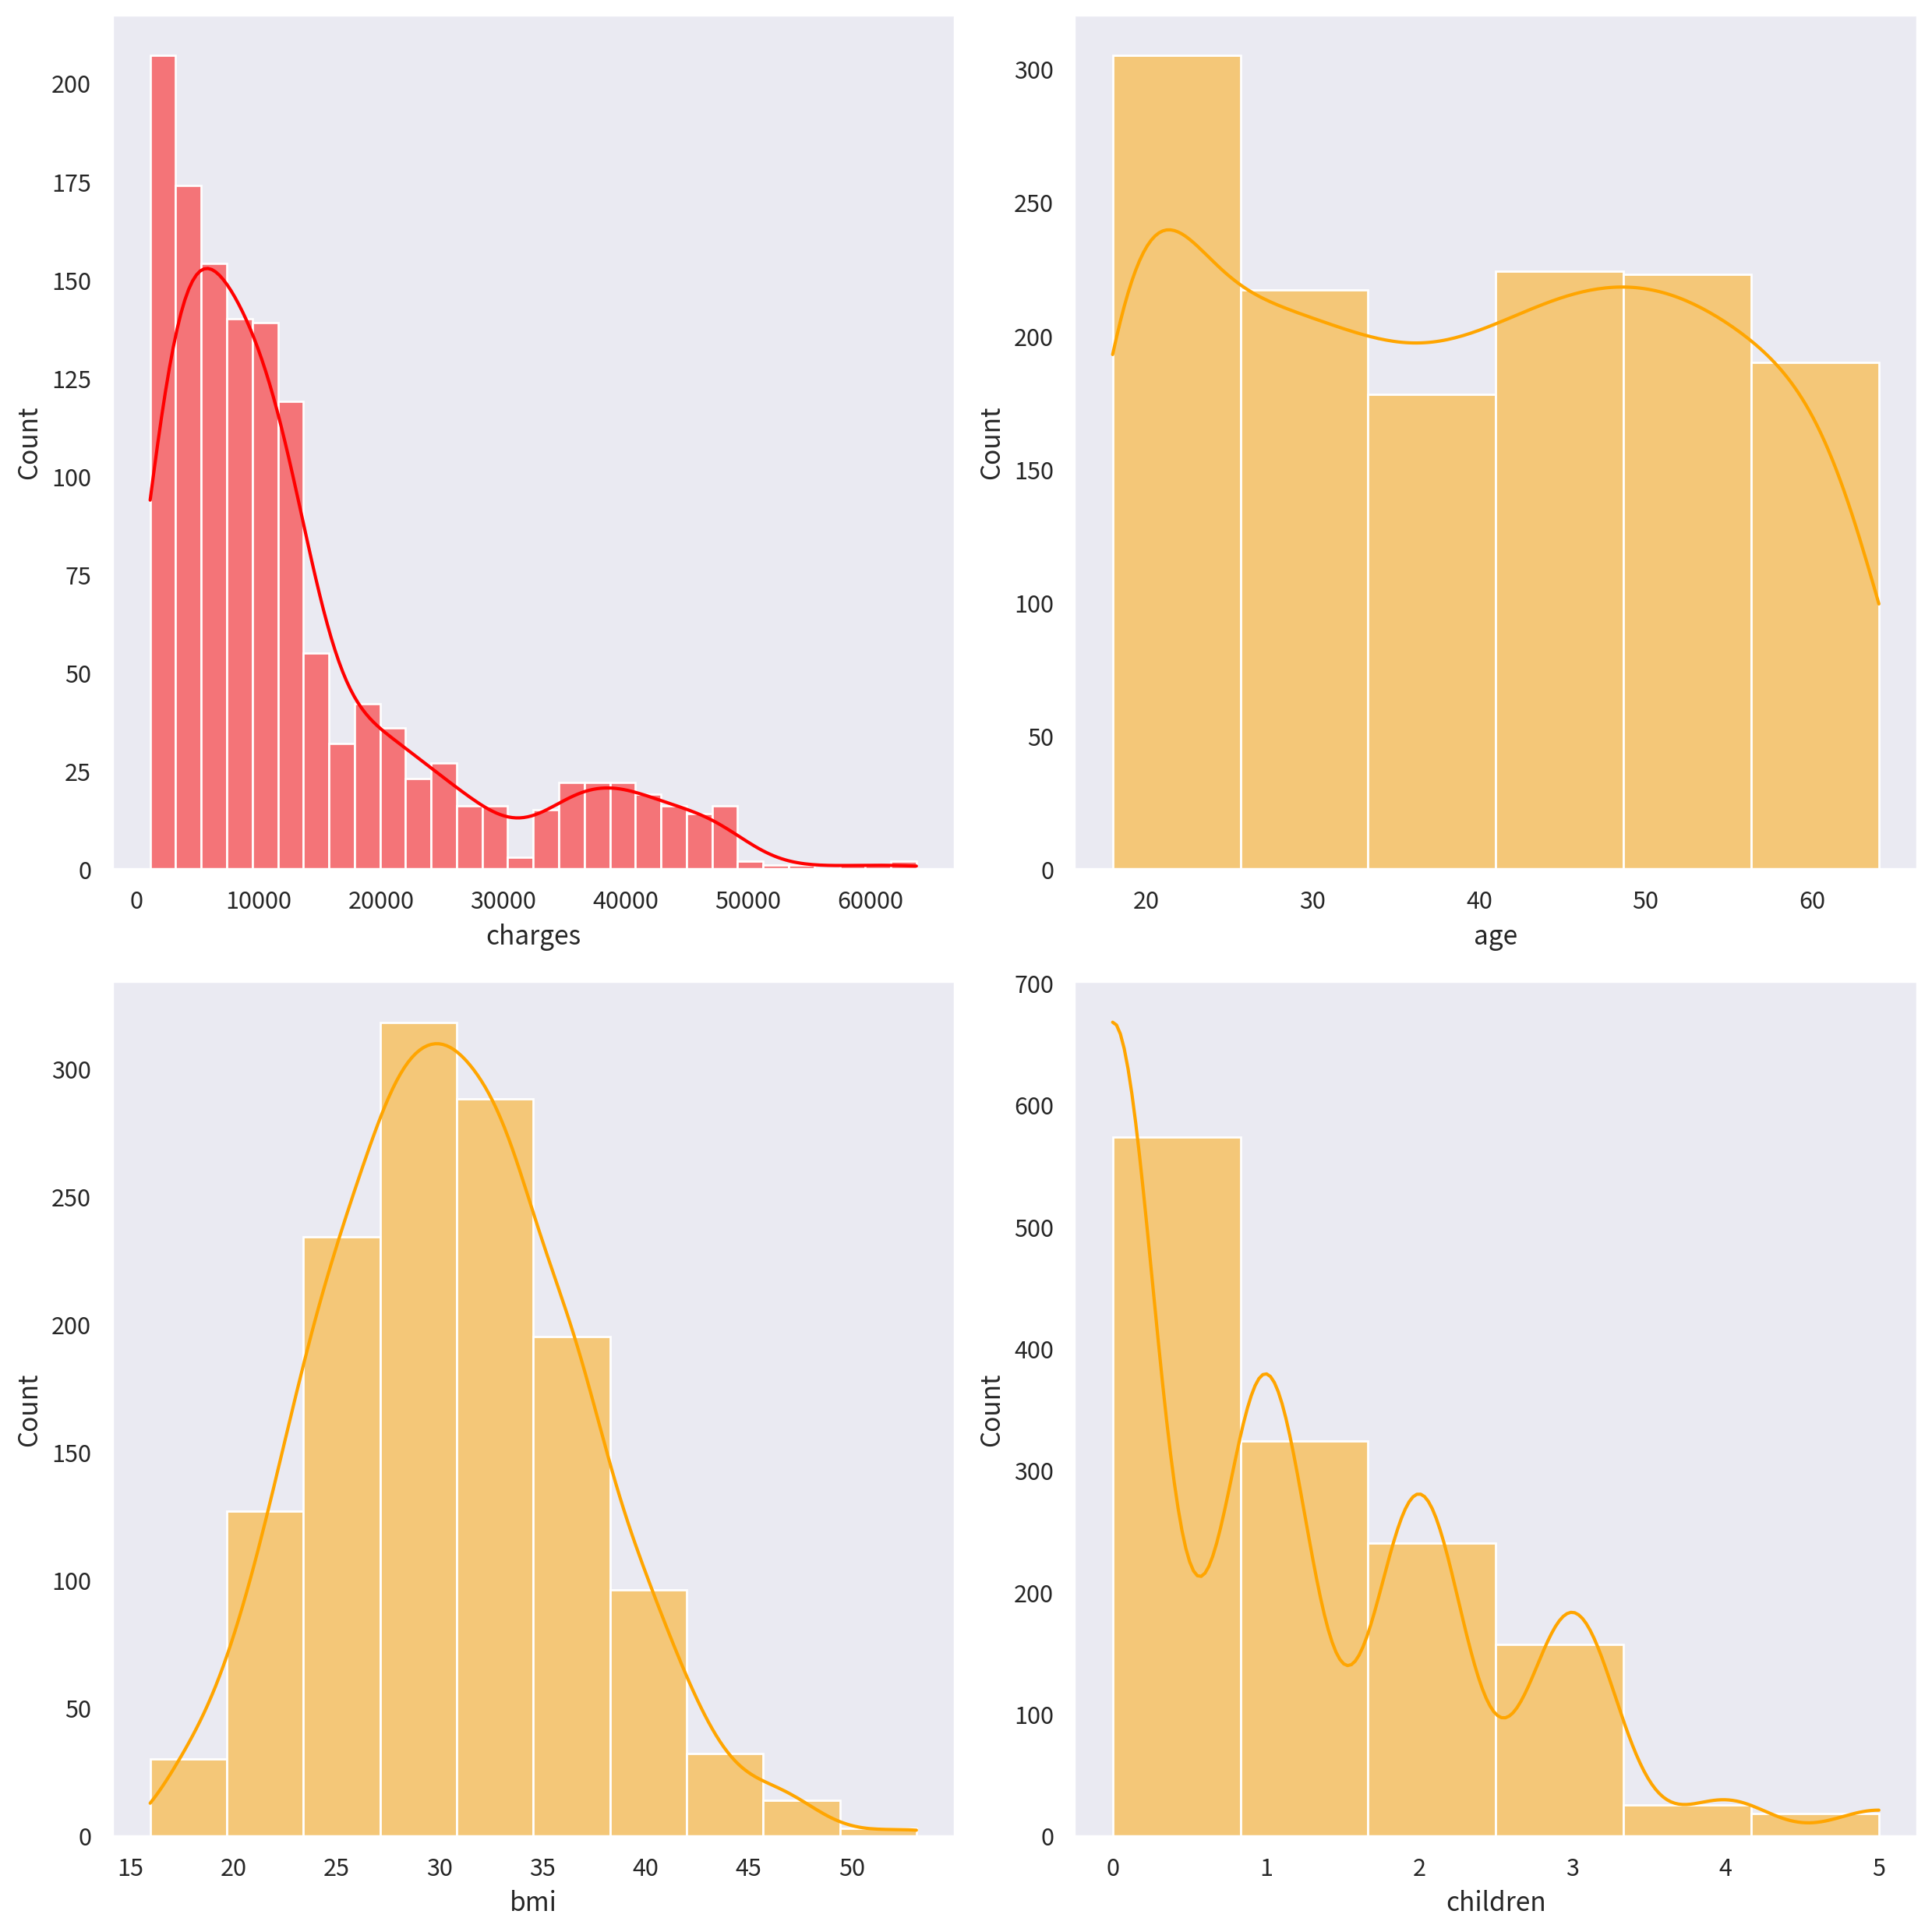

In [13]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 2                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df, x='charges', bins=30, kde=True, color='red', ax=ax[0,0])
sb.histplot(data=df, x='age', bins=6, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df, x='bmi', bins=10, kde=True, color='orange', ax=ax[1,0])
sb.histplot(data=df, x='children', bins=6, kde=True, color='orange', ax=ax[1,1])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 대부분의 charges는 0~15000USD를 지불하는 듯 
    - 일부 고액을 내는 사람이 존재 (20000~50000)
    - 왼쪽으로 치우쳐져있음
- 나이대는 20대가 가장 많고 50대가 그 다음, 나머지 30,40,60대는 비슷함
- bmi 지수는 25~35 사이에 몰려있으며 정규 분포 형태를 띔
- 아이들은 1명 이하인 사람이 많은 것을 알 수 있음. 
    - 왼쪽으로 치우쳐져있음.

### 미션 3. 로그/비선형 변환을 고민해보자.

- charges 혹은 주요 변수(age, bmi, children)에 로그/제곱근 등 변환을 적용해 전후 분포를 나란히 비교한다.
- 변환이 해석과 모델 적합에 주는 장단점, 해석이 어떻게 달라지는지 예상한다.
- 이 변환이 없으면 어떤 함정에 빠질까?를 한 줄로 정리한다.
- 선택 기준을 명시하세요. 왜 log(charges)인지, 왜 특정 변수에 변환을 적용하는지 데이터 분포 근거로 설명합니다.

charges에 로그 변환 적용, bmi는 왜도가 심하지 않고 children은 변환의 필요를 못느낌, 실제 값을 사용하는게 더 좋을듯이라고 일단 생각하고 진행

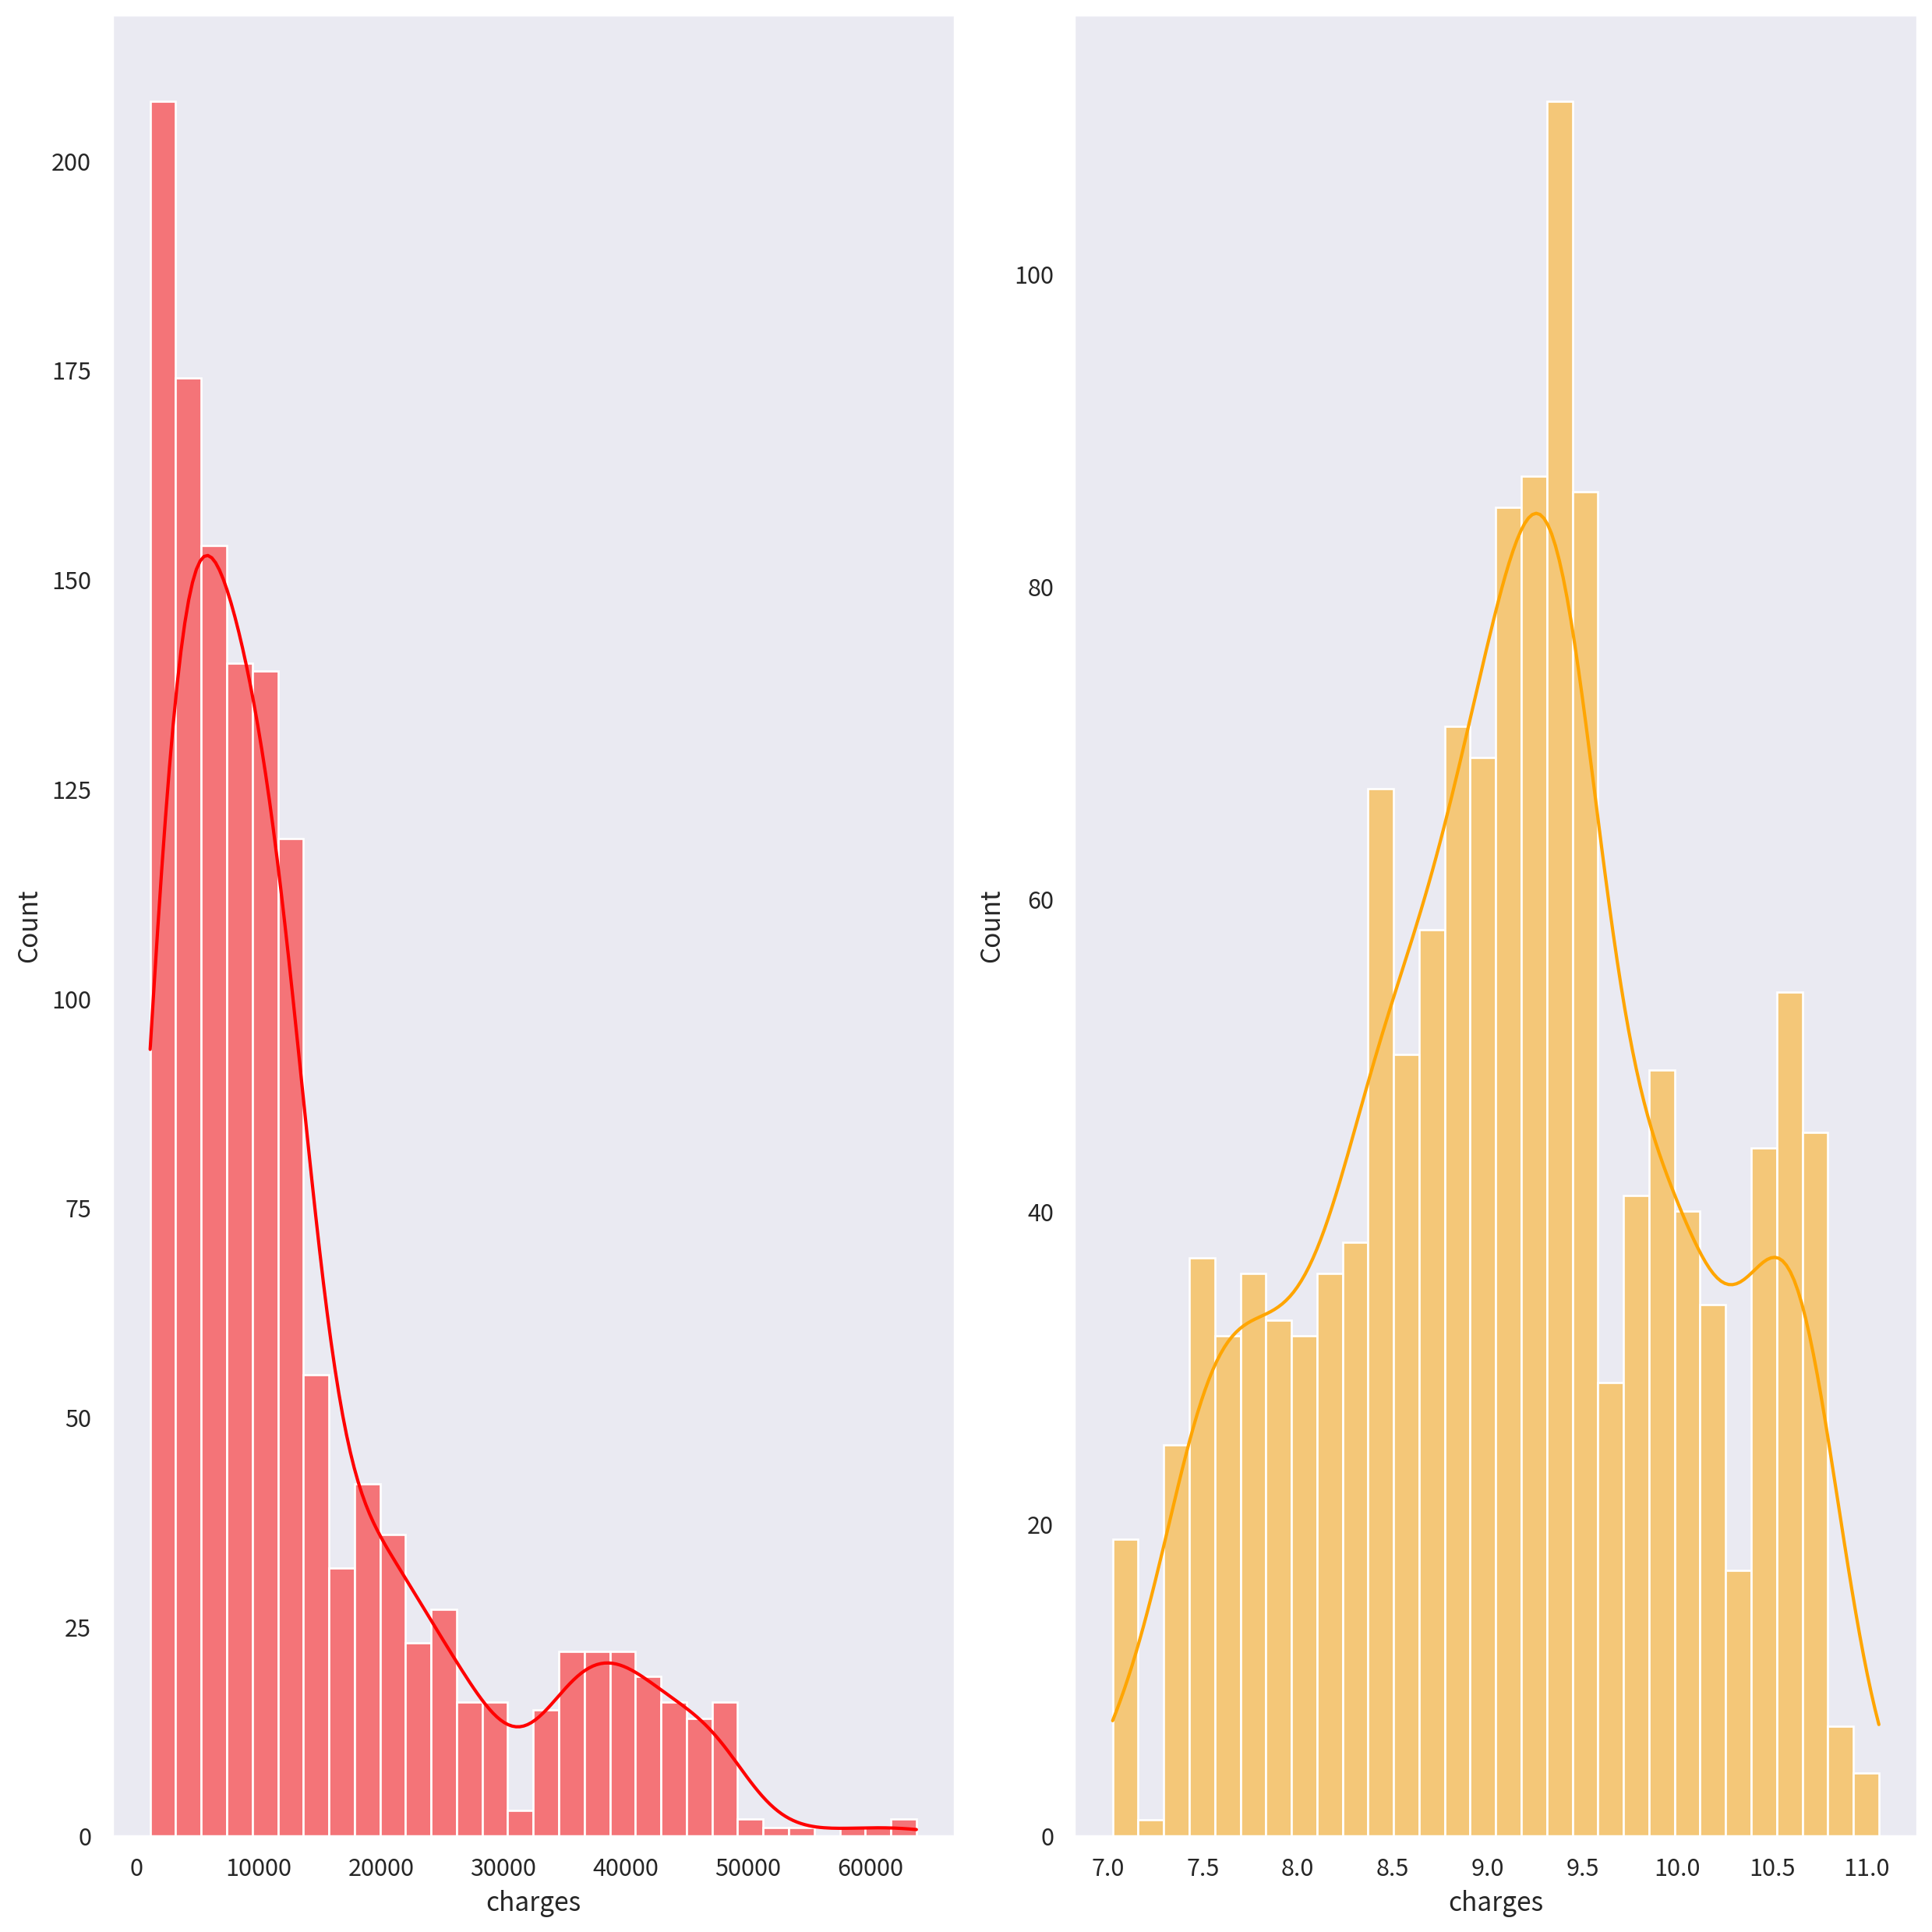

In [14]:
#charges 변수에 로그 변환 적용
df2=df.copy()
df2['charges'] = np.log1p(df2['charges'])

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df, x='charges', bins=30, kde=True, color='red', ax=ax[0])
sb.histplot(data=df2, x='charges', bins=30, kde=True, color='orange', ax=ax[1])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 의료비의 대부분이 소액에 집중되어 있기 때문에 오른쪽 꼬리가 생김
- 로그 변환을 적용하여 정규 분포에 가까운 형태로 만들어줌
    - 모델이 고액 데이터들(이상치)에게로부터 안정적으로 학습할 수 있음 
    - 로그 변환을 하지 않을 경우 이상치가 모델 전체를 왜곡시켜 대다수 일반 사용자의 의료비를 과대, 과소로 예측하게 될 수 있음.

### 미션 4. 성별과 거주 지역은 의료비를 결정할까?
- 성별(sex)과 지역(region)별 의료비 분포를 시각화(박스플롯, 바이올린 플롯)한다.
- 중앙값, 분포 겹침을 근거로 어느 집단이 비싼가? 차이가 얼마나 뚜렷한가? 를 문장으로 적으세요.
- 왜 이런 차이가 생겼을까?를 건강보험 체계,지역 의료 인프라, 생활 비용 차이 등으로 추정해보세요.

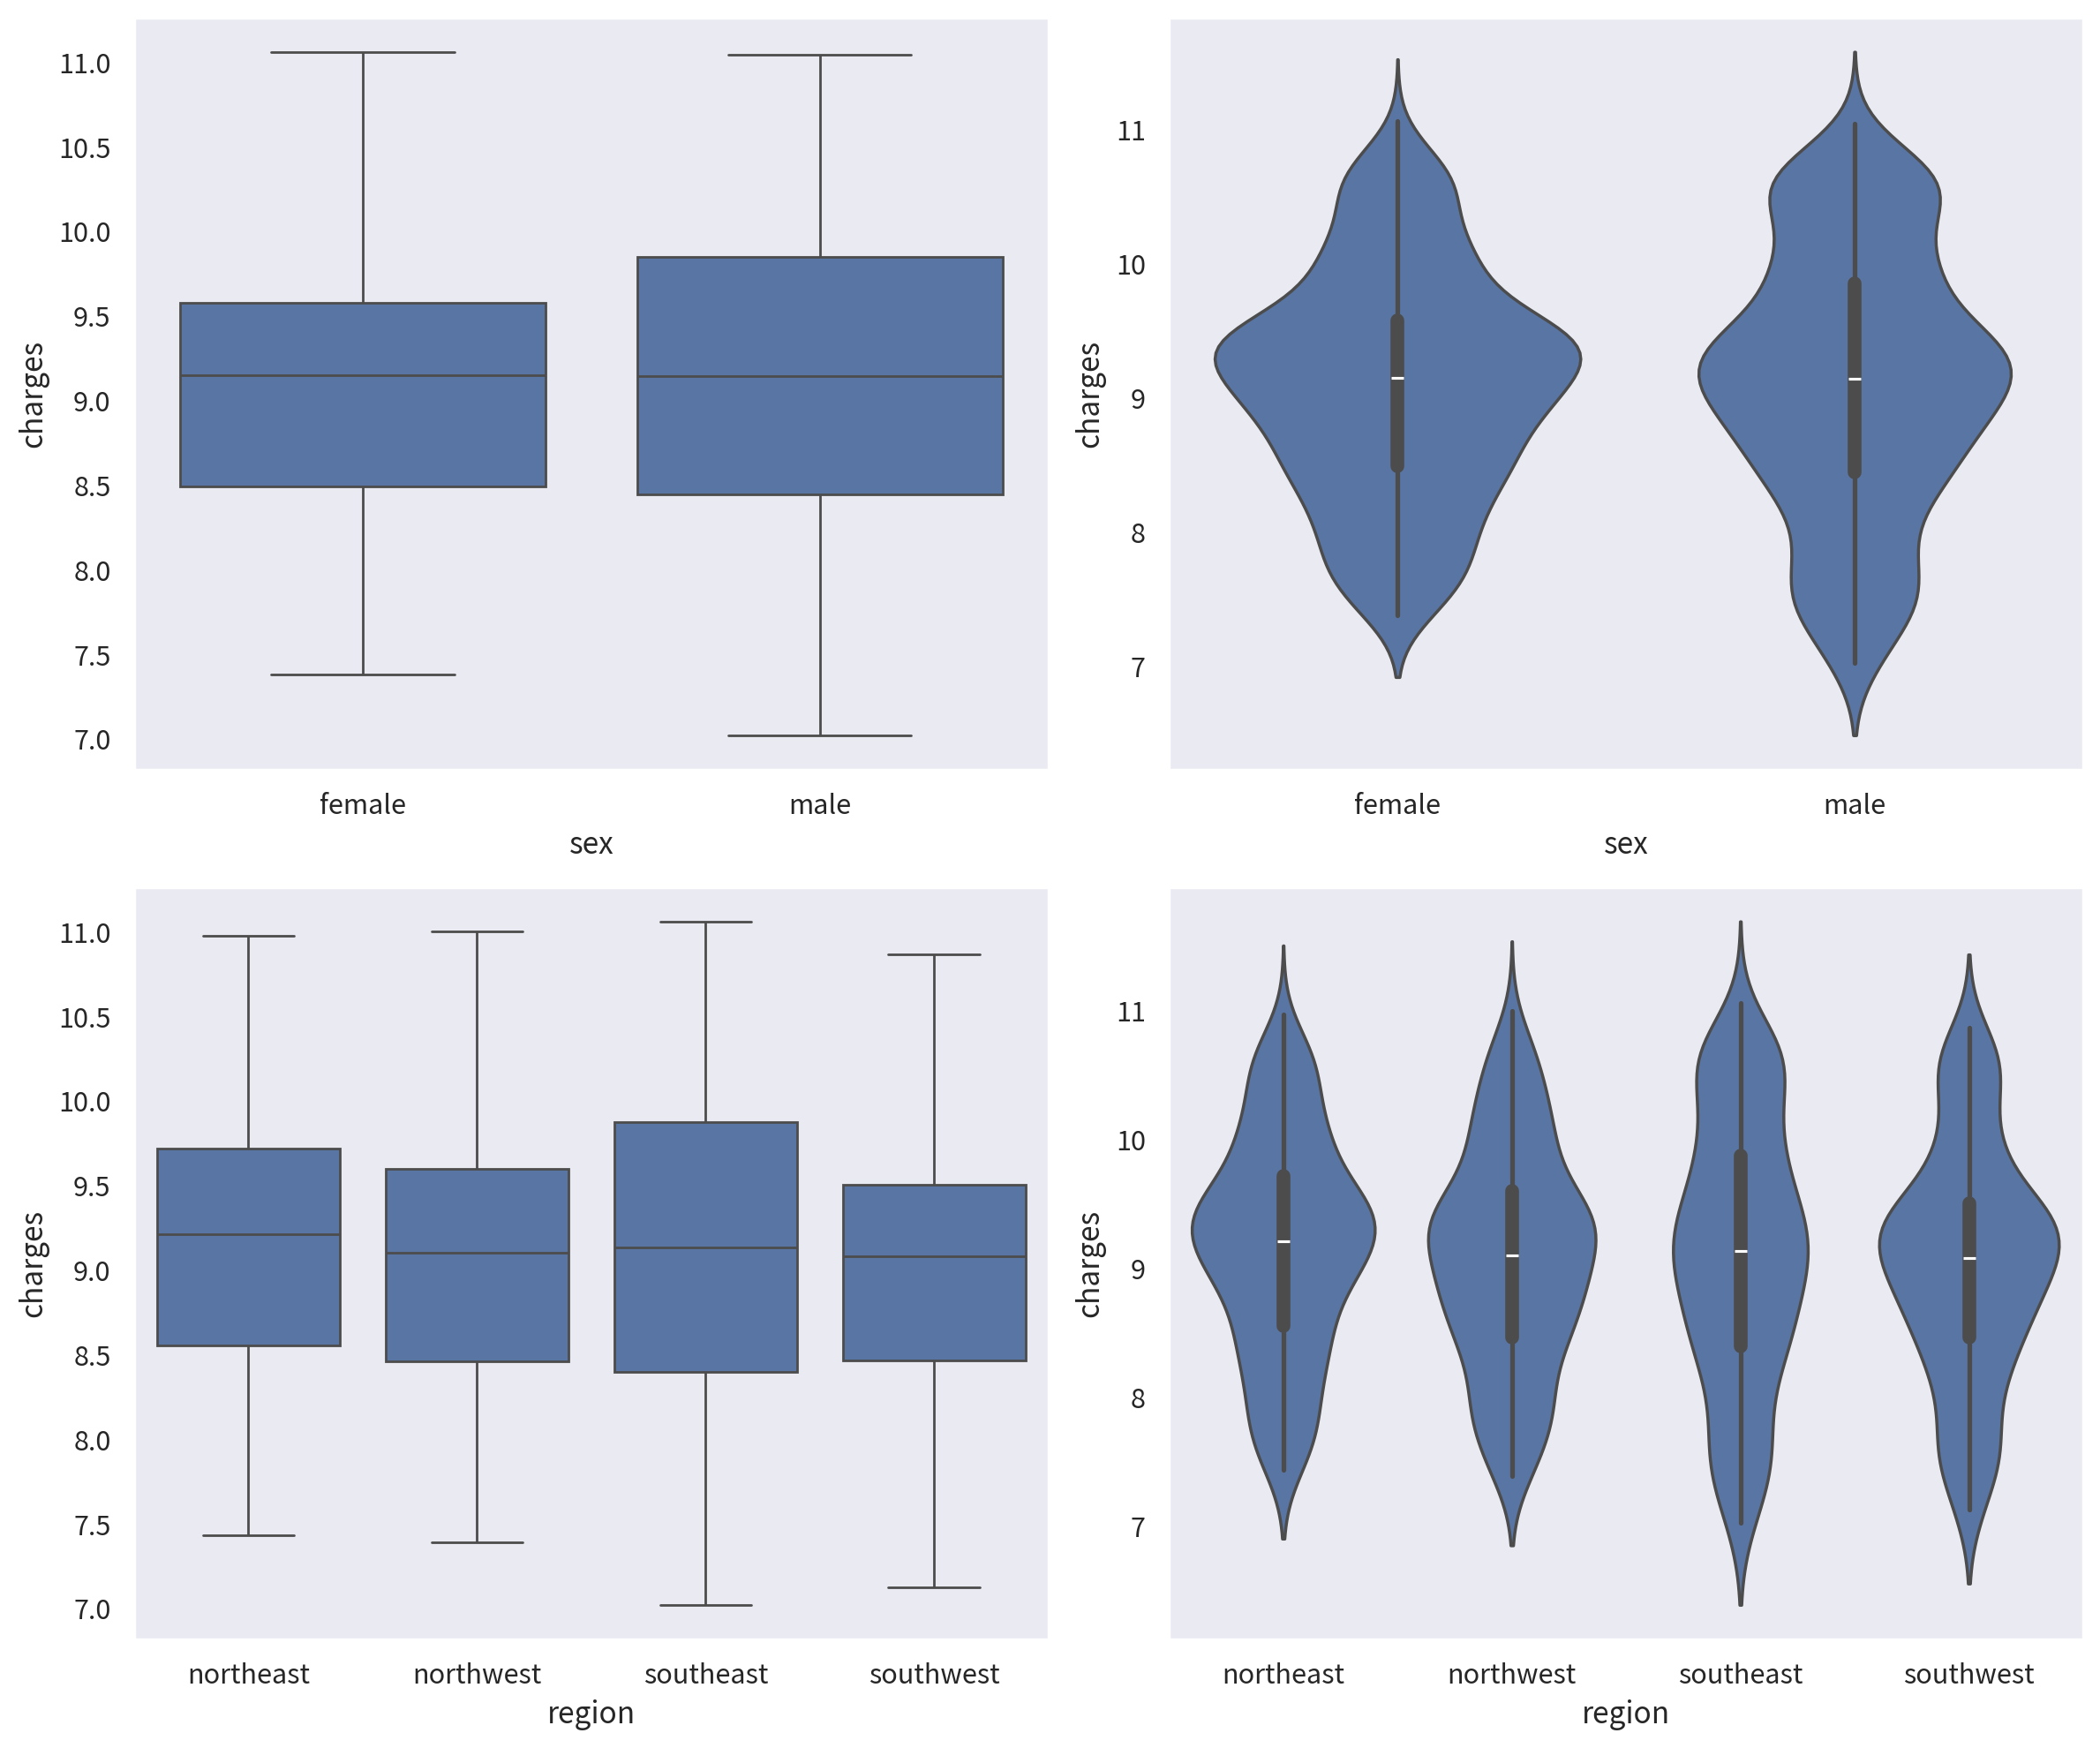

In [18]:
#성별과 지역별 의료비 분포 시각화 (박스플롯, 바이올린 플롯)
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=my_dpi)
sb.boxplot(data=df2, x='sex', y='charges', ax=ax[0][0])
sb.violinplot(data=df2, x='sex', y='charges', ax=ax[0][1])
sb.boxplot(data=df2, x='region', y='charges', ax=ax[1][0])
sb.violinplot(data=df2, x='region', y='charges', ax=ax[1][1])  

plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료


- 성별의 경우 남성과 여성 둘 다 중앙값은 비슷한 위치에 존재함
    - 남성의 경우 여성에 비해 고액이 많이 나타남
- 지역의 경우 4개 지역의 박스 높이와 위치가 비슷함
    - southeast의 경우 바이올린 플롯이 더 얇고 위로 길게 뻗어있는 것을 보아 고액 의료비를 내는 사람이 더 많음
    - 거주 지역 자체가 의료비를 결정하지는 않지만 지역별 생활 습관이나 의료 인프라 차이로 의료비 청구 비율이 달라질 수 있다고 생각함.

### 미션 5. 흡연은 정말로 의료비를 크게 높일까?
- smoker(흡연 여부)에 따라 charges가 다른지 시각화하고, 두 집단 평균 차이를 가설검정(t-test)으로 확인한다.
- 효과 크기(차이의 크기)를 함께 제시하고, 실제로 의미있는 차이인가?를 말로 해석하세요.
- 정규성/등분산 가정 점검 후 필요 시 Welch's t-test나 비모수 검정을 선택하세요.
- 효과 크기를 의료 정책 관점에서 의미를 서술합니다.

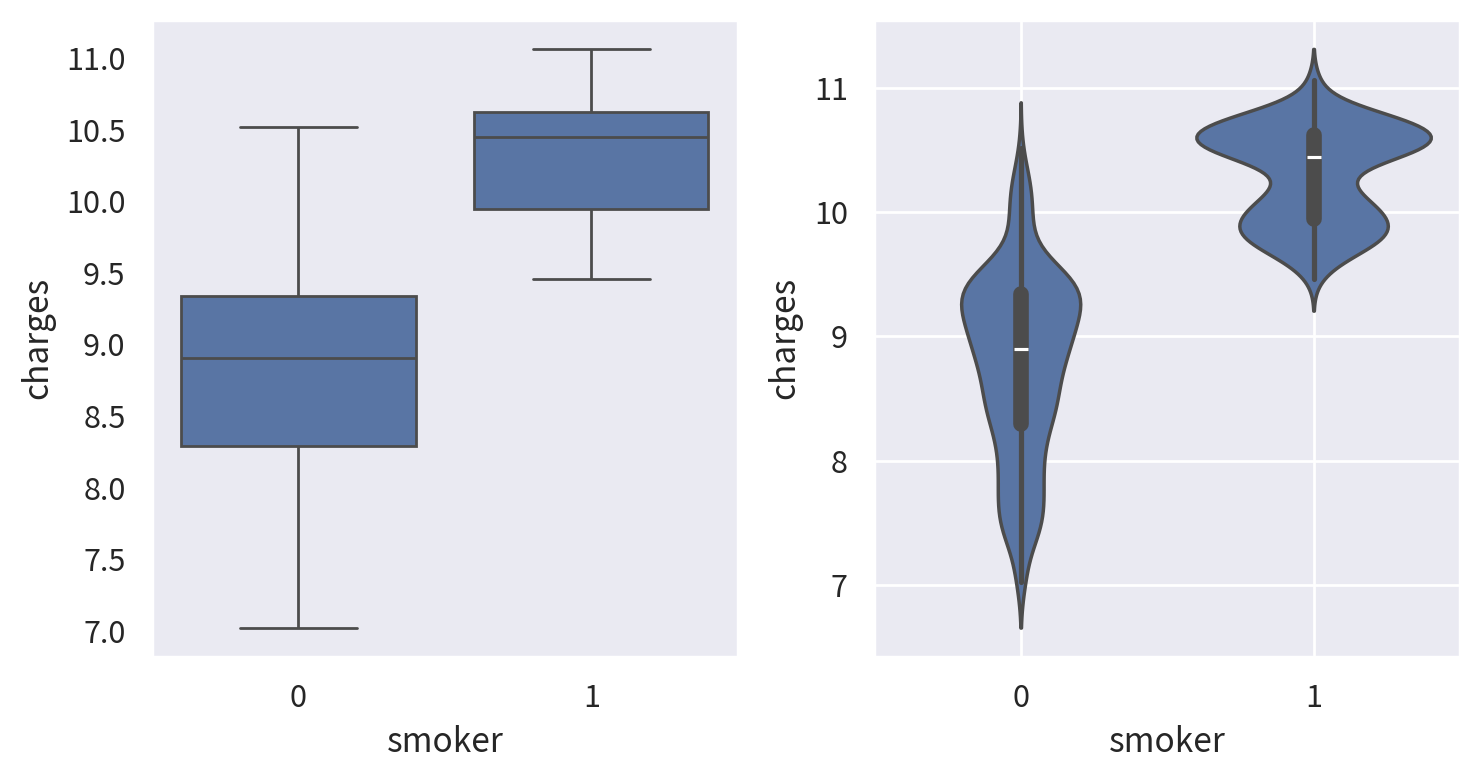

In [21]:
#smoker에 따라 charges가 다른지 시각화
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1500             #그래프 가로 크기
height_px = 800             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 2                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)
# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df2, x='smoker', y='charges', ax=ax[0])
sb.violinplot(data=df2, x='smoker', y='charges', ax=ax[1])
# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)
# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료


In [29]:
#두 집단 평균 차이를 가설검정(t-test)으로 확인
smoker_1 = df2[df2['smoker']==1]['charges']
smoker_0 = df2[df2['smoker']==0]['charges']

s_1, p_1 = shapiro(smoker_1)
print("statistic: {0:.3f}, p-value: {1:.3f}, 정규성 충족 여부: {2}".format(s_1,p_1, p_1>0.05))
s_0, p_0 = shapiro(smoker_0)
print("statistic: {0:.3f}, p-value: {1:.3f}, 정규성 충족 여부: {2}".format(s_0,p_0, p_0>0.05))

statistic: 0.929, p-value: 0.000, 정규성 충족 여부: False
statistic: 0.976, p-value: 0.000, 정규성 충족 여부: False


정규성 충족하지 않으니 비모수 검정 진행

- 귀무가설 : 흡연자와 비흡연자의 평균 의료보험 청구 비용은 차이가 없다.
- 대립가설 : 흡연자와 비흡연자의 평균 의료보험 청구 비용은 차이가 있다.

In [34]:
#비모수 검정 Welch's t-test 수행
s,p = ttest_ind(smoker_1, smoker_0, equal_var=False)
print("statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s,p,"대립" if p<=0.05 else "귀무"))

statistic: 46.347, p-value: 0.000, 대립가설 채택


- 대립가설 채택으로 흡연자와 비흡연자의 평균 의료보험 청구 비용은 차이가 있음.
- 박스플롯의 형태만 보아도 흡연자와 비흡연자의 평균 의료보험 청구 비용은 존재한다고 유추할 수 있음.
- statistic이 의미하는 바 : 두 집단의 평균이 얼마나 멀리 떨어져있나?
    - 현재 46.347로 흡연자의 의료비가 더 높은 것을 의미함
    - 매우 유의미한 차이로 흡연은 보험료의 불평등을 초래하는 결정적인 상승 요인이며 흡연자에 대한 금연 지원 사업이 필요함을 보여줌. 
        - 흡연자들의 평균 의료보험 청구 비용이 왜 높은가? 에 대한 의문이 생김
        - 단순 흡연자들에게 보험료를 더 높게 부과하는 것일지, 흡연자들의 잔병치레가 있기에 보험비를 많이 타서 보험료가 많이 올라가는 것인지?

### 미션 6. 나이대별로 의료비 차이가 뚜렷할까?
- age를 여러구간으로 나누어(ex: 18~30, 31~50, 51+) 각 연령대별 charges 분포를 시각화한다.
- 분산분석(ANOVA)으로 전체 차이를 확인하고, 사후검정으로 어느 연령대 사이에서 차이가 나는지 정리한다.
- 사후검정은 Tukey HSD 또는 Games-Howell(등분산 위반 시)을 사용하고, 의료비 연령 서열표 형태로 요약하세요.

In [38]:
# 연령대 정의: 청년(18-30), 중년(31-50), 노년(51+)
bins = [0, 30, 50, 100]
labels = ['Young(18-30)', 'Middle(31-50)', 'Senior(51+)']
df2['age_group'] = pd.cut(df2['age'], bins=bins, labels=labels)

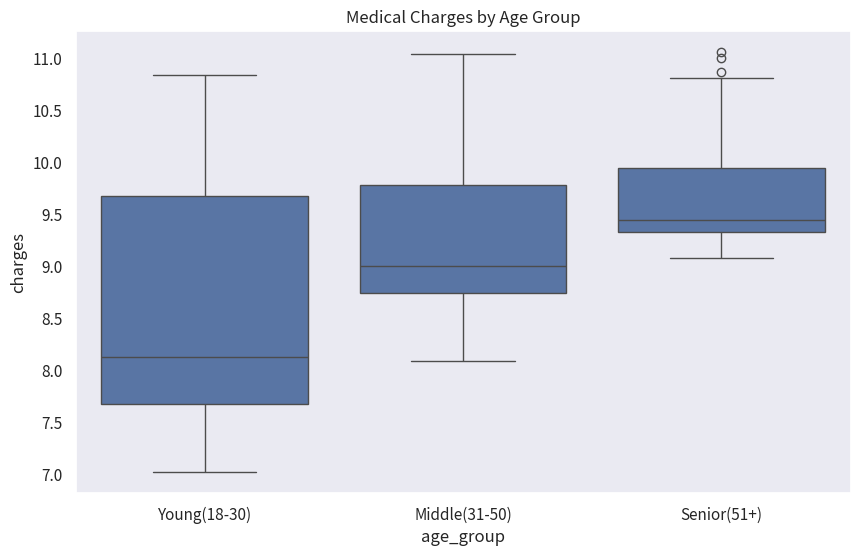

In [39]:
plt.figure(figsize=(10, 6))
sb.boxplot(x='age_group', y='charges', data=df2)
plt.title('Medical Charges by Age Group')
plt.show()

In [ ]:
# 각 그룹의 데이터 분리
g1 = df2[df2['age_group'] == 'Young(18-30)']['charges']
g2 = df2[df2['age_group'] == 'Middle(31-50)']['charges']
g3 = df2[df2['age_group'] == 'Senior(51+)']['charges']

f_val, p_val = f_oneway(g1, g2, g3)
print(f"ANOVA F-statistic: {f_val:.3f}, p-value: {p_val:.3e}")

ANOVA F-statistic: 210.871, p-value: 2.653e-80
